Github link: https://github.com/genom10/Sensors2023/tree/master/HW7

# Task 7

## Camera calibration



In [95]:
# !unzip data.zip

In [96]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

In [97]:
PATTERN_SIZE = (5, 7)
SQUARE_SIZE = 35
SCALE_FACTOR = 0.25

@dataclass
class CameraParams:
  img_points: list
  obj_points: list
  rms: float
  camera_matrix: np.ndarray
  dist_coefs: np.ndarray
  rvecs: Tuple[np.ndarray, ...]
  tvecs: Tuple[np.ndarray, ...]

In [98]:
def rescale_frame(frame, scale=0.75):
  width = int(frame.shape[1] * scale)
  height = int(frame.shape[0] * scale)
  dimensions = (width, height)

  return cv2.resize(frame, dimensions, interpolation=cv2.INTER_AREA)

def get_camera_points(img_mask: str, verbose: bool = False) -> CameraParams:
  figsize = (20, 20)

  img_names = glob(img_mask)

  pattern_points = np.zeros((np.prod(PATTERN_SIZE), 3), np.float32)
  pattern_points[:, :2] = np.indices(PATTERN_SIZE).T.reshape(-1, 2)
  pattern_points *= SQUARE_SIZE
  obj_points = []
  img_points = []
  h, w = cv2.imread(img_names[0]).shape[:2]
  h = int(SCALE_FACTOR * h)
  w = int(SCALE_FACTOR * w)

  plt.figure(figsize=figsize)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

  for i, fn in enumerate(img_names):
    print("processing %s... " % fn)
    imgBGR = cv2.imread(fn)

    if imgBGR is None:
      print("Failed to load", fn)
      continue

    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(imgRGB, cv2.COLOR_BGR2GRAY)
    img = rescale_frame(img, SCALE_FACTOR)
    imgRGB = rescale_frame(imgRGB, SCALE_FACTOR)

    # Finds the positions of internal corners of the chessboard.
    # image  Source chessboard view. It must be an 8-bit grayscale or color image.
    # patternSize  Number of inner corners per a chessboard row and column.
    # corners  Output array of detected corners.
    found, corners = cv2.findChessboardCorners(img, PATTERN_SIZE)

    if not found:
      print("chessboard not found")
      continue
    # refining pixel coordinates for given 2d points.
    corners2 = cv2.cornerSubPix(img, corners, (10,10),(-1,-1), criteria)

    # Draw and display the corners  
    if verbose:
      img_w_corners = cv2.drawChessboardCorners(imgRGB, PATTERN_SIZE, corners2, found)
      plt.plot()
      plt.imshow(img_w_corners)
      plt.show()

    print(f"{fn}... OK")
    img_points.append(corners2)
    obj_points.append(pattern_points)

  return CameraParams(
    obj_points, img_points, *cv2.calibrateCamera(
      obj_points, img_points, (w, h), None, None
    )
  )

In [99]:
cameraParamsLeft = get_camera_points("./data/left_chessboard/*.jpg")
cameraParamsRight = get_camera_points("./data/right_chessboard/*.jpg")

processing ./data/left_chessboard/1.jpg... 
./data/left_chessboard/1.jpg... OK
processing ./data/left_chessboard/5.jpg... 
chessboard not found
processing ./data/left_chessboard/2.jpg... 
./data/left_chessboard/2.jpg... OK
processing ./data/left_chessboard/4.jpg... 
chessboard not found
processing ./data/left_chessboard/11.jpg... 
./data/left_chessboard/11.jpg... OK
processing ./data/left_chessboard/8.jpg... 
./data/left_chessboard/8.jpg... OK
processing ./data/left_chessboard/6.jpg... 
./data/left_chessboard/6.jpg... OK
processing ./data/left_chessboard/3.jpg... 
./data/left_chessboard/3.jpg... OK
processing ./data/left_chessboard/9.jpg... 
./data/left_chessboard/9.jpg... OK
processing ./data/left_chessboard/10.jpg... 
chessboard not found
processing ./data/left_chessboard/7.jpg... 
chessboard not found
processing ./data/right_chessboard/1.jpg... 
./data/right_chessboard/1.jpg... OK
processing ./data/right_chessboard/5.jpg... 
chessboard not found
processing ./data/right_chessboard/2.

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [100]:
def plot_undistorted(img_mask: str, cameraParams : CameraParams):
    figsize = (20, 20)
    plt.figure(figsize=figsize)

    img_names = glob(img_mask)
    for i, fn in enumerate(img_names):

        imgBGR = cv2.imread(fn)
        imgBGR = rescale_frame(imgBGR, SCALE_FACTOR)
        imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
        dst = cv2.undistort(imgRGB, cameraParams.camera_matrix, cameraParams.dist_coefs)

        if i < 12:
            plt.subplot(4, 3, i + 1)
            plt.imshow(dst)

    plt.show()
    print("Done")

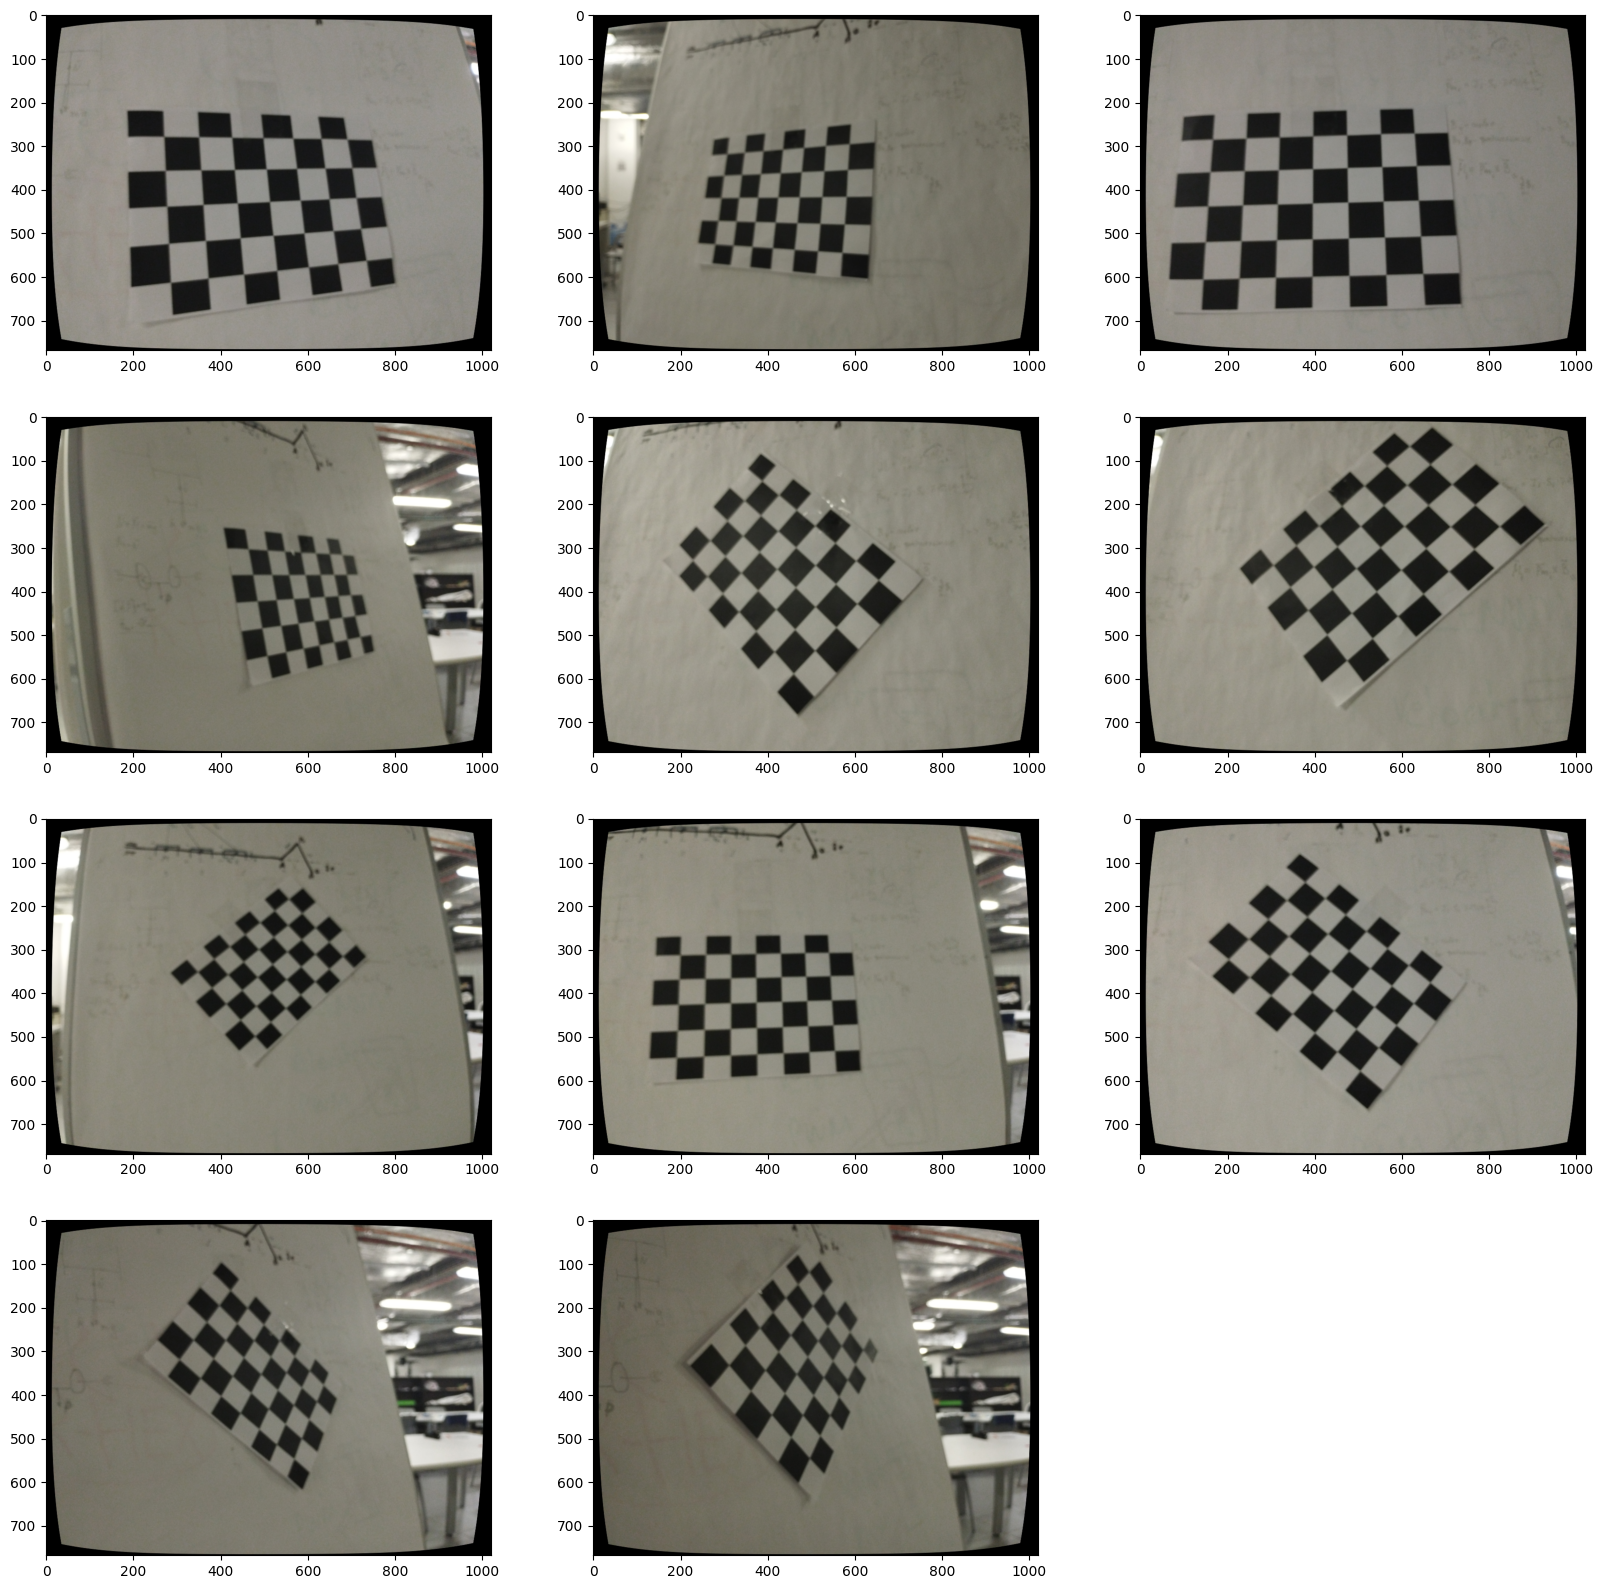

Done


In [101]:
plot_undistorted("./data/left_chessboard/*.jpg", cameraParamsLeft)

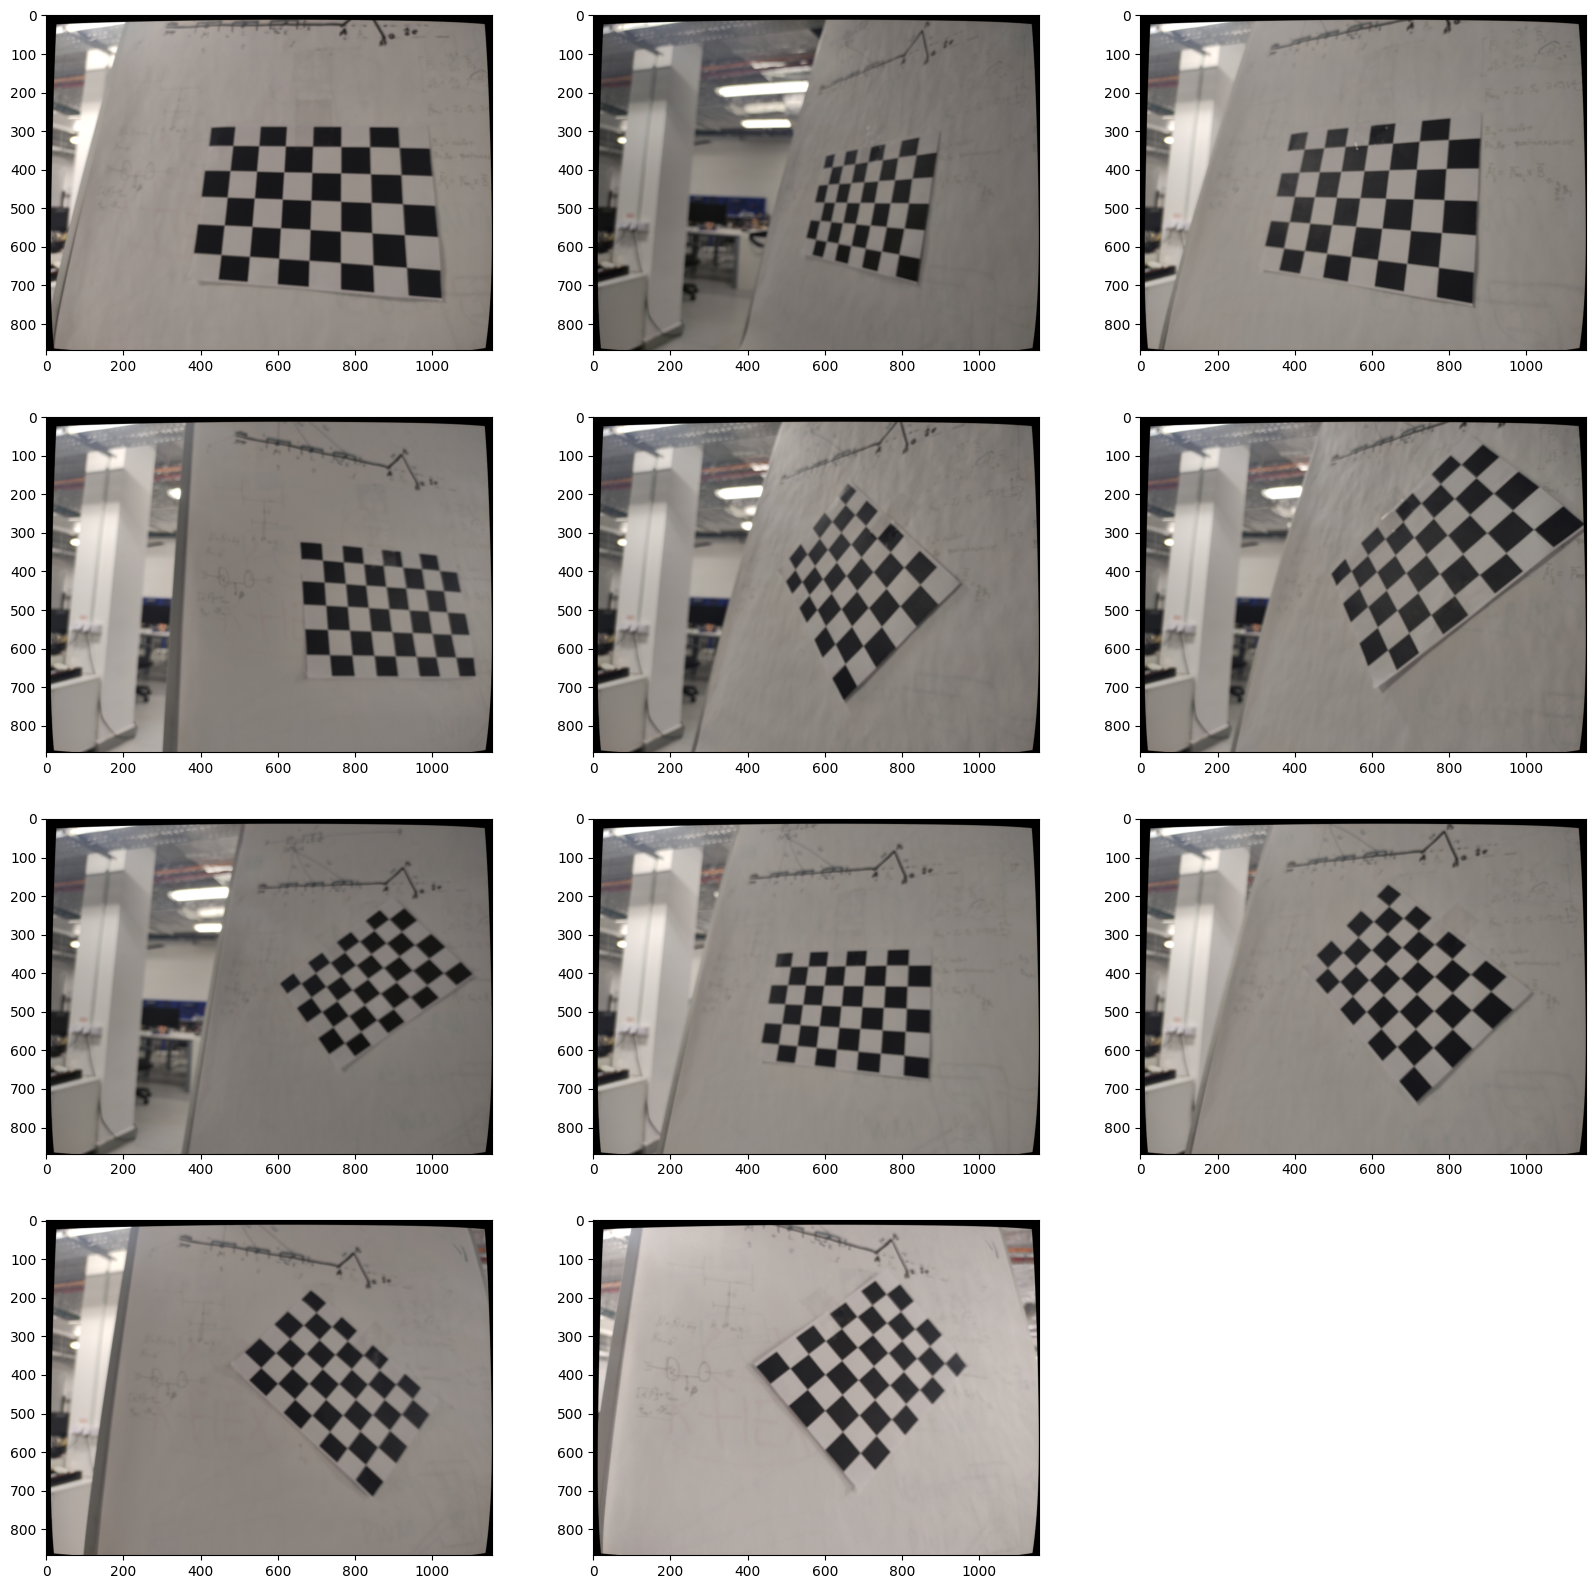

Done


In [102]:
plot_undistorted("./data/right_chessboard/*.jpg", cameraParamsRight)

In [103]:
# Reading the Image
def findPerson(img_name: str, cameraParams : CameraParams):
   image = cv2.imread(img_name)
   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
   image = rescale_frame(image, SCALE_FACTOR)
   dst = cv2.undistort(image, cameraParams.camera_matrix, cameraParams.dist_coefs)

   # initialize the HOG descriptor
   hog = cv2.HOGDescriptor()
   hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

   # detect humans in input image
   (humans, _) = hog.detectMultiScale(image, winStride=(10, 10),
   padding=(32, 32), scale=1.1)

   # getting no. of human detected
   print('Human Detected : ', len(humans))

   # loop over all detected humans
   for (x, y, w, h) in humans:
      pad_w, pad_h = int(0.15 * w), int(0.01 * h)
      cv2.rectangle(image, (x + pad_w, y + pad_h), (x + w - pad_w, y + h - pad_h), (0, 255, 0), 2)

   # display the output image
   plt.imshow(image)
   return humans

Human Detected :  0


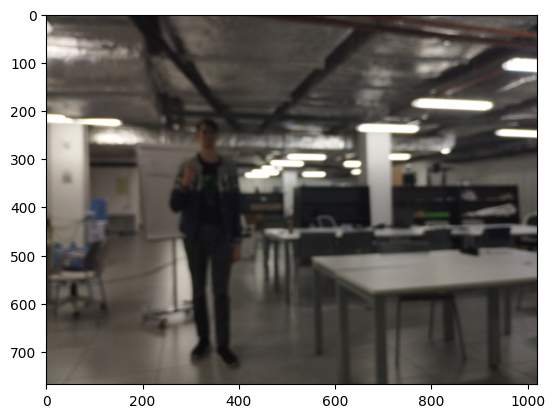

In [105]:
humansL = findPerson('./data/left_man/3.jpg', cameraParamsRight)

Human Detected :  1


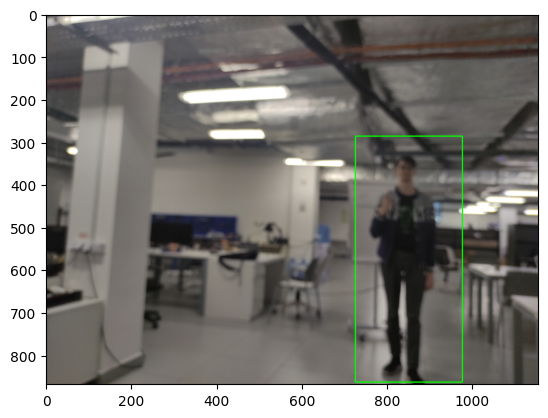

In [114]:
humansR = findPerson('./data/right_man/3.jpg', cameraParamsRight)

## Compute the disparity map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


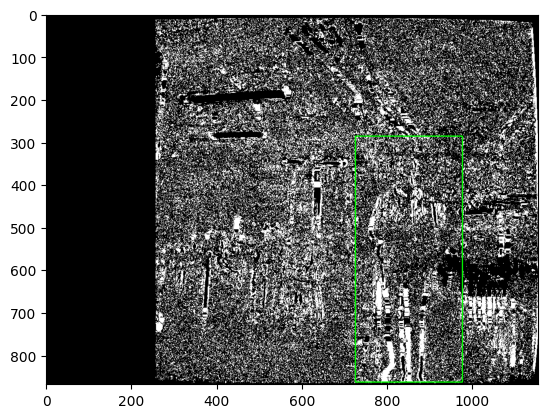

In [116]:
imgL = cv2.imread('./data/left_man/3.jpg', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('./data/right_man/3.jpg', cv2.IMREAD_GRAYSCALE)
imgL = rescale_frame(imgL, SCALE_FACTOR)
imgR = rescale_frame(imgR, SCALE_FACTOR)
imgL = cv2.undistort(imgL, cameraParamsLeft.camera_matrix, cameraParamsLeft.dist_coefs)
imgR = cv2.undistort(imgR, cameraParamsRight.camera_matrix, cameraParamsRight.dist_coefs)
imgL = cv2.resize(imgL, (imgR.shape[1], imgR.shape[0]))

stereo = cv2.StereoBM_create(numDisparities=256, blockSize=5)
disparity = stereo.compute(imgR, imgL)

img_float32 = np.float32(disparity)
disparityRGB = cv2.cvtColor(img_float32, cv2.COLOR_GRAY2RGB)

for (x, y, w, h) in humansR:
    pad_w, pad_h = int(0.15 * w), int(0.01 * h)
    cv2.rectangle(disparityRGB, (x + pad_w, y + pad_h), (x + w - pad_w, y + h - pad_h), (0, 255, 0), 2)

plt.imshow(disparityRGB)
plt.show()